In [238]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
from numpy.random import default_rng
import cvxpy as cp
import networkx as nx
import mosek
import custom_networks

from solution_files_manager import SolutionFilesManager
from opt_utils import decompose_psd, complex_hyperplane_rounding, fixed_point_iteration
from opf_utils import *

In [239]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [240]:
case = "case30"
net = custom_networks.get_case(case)
n = len(net.bus)

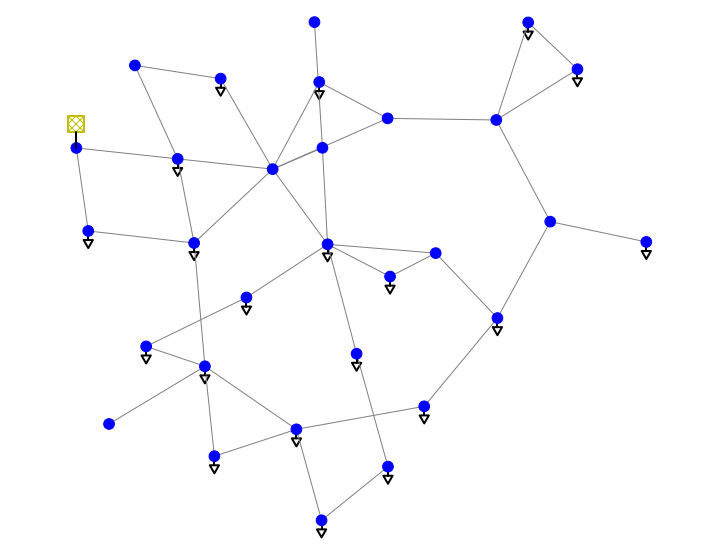

<AxesSubplot:>

In [241]:
simple_plot(net, plot_loads=True, plot_sgens=True)

#### Generators57

In [242]:
gen_df_list = []
gen_class_list = ["ext_grid", "gen", "sgen"]  # the 3 types of generators
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_class in gen_class_list:
    if not net[gen_class].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_class_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_class].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_class_df = net[gen_class][data_col_list].join(gen_class_poly_cost)
        gen_df_list.append(gen_class_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)
gens = gen_df["bus"].to_numpy()

In [243]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,80.0,0.0,150.0,-20.0,ext_grid,0.0,2.00,0.02000,0.0,0.0,0.0
1,0,1,80.0,0.0,60.0,-20.0,gen,0.0,1.75,0.01750,0.0,0.0,0.0
2,1,21,50.0,0.0,62.5,-15.0,gen,0.0,1.00,0.06250,0.0,0.0,0.0
3,2,26,55.0,0.0,48.7,-15.0,gen,0.0,3.25,0.00834,0.0,0.0,0.0
4,3,22,30.0,0.0,40.0,-10.0,gen,0.0,3.00,0.02500,0.0,0.0,0.0
5,4,12,40.0,0.0,44.7,-15.0,gen,0.0,3.00,0.02500,0.0,0.0,0.0


#### Bus loads

In [244]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [245]:
load_df

,p_mw,q_mvar
0,0.0,0.0
1,21.7,12.7
2,2.4,1.2
3,7.6,1.6
4,0.0,0.0
5,0.0,0.0
6,22.8,10.9
7,30.0,30.0
8,0.0,0.0
9,5.8,2.0


#### Admittance matrices

In [246]:
# compute line susceptance in p.u.
net.line['s_pu'] = net.line['c_nf_per_km'] * net.line["length_km"] * (2 * np.pi * net.f_hz) * \
    ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2) / net.sn_mva / net.line['parallel'] / 1e9

In [247]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

In [248]:
G_val, B_val, Y_val = compute_admittance_mat(net, graph)

## Variables

In [249]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [250]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [251]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
# TODO: check whether these are for net injections (supply - demand) or for generated power (supply)
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [252]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [253]:
# SOCP constraint
# constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

### SDP (non-QCQP)

In [254]:
constraints = [X >> 0]

for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

In [255]:
p_cost = c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0)
q_cost = c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0)

In [256]:
# original cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# heuristic penalization
# prob = cp.Problem(cp.Minimize(p_cost + q_cost + 0.5 * cp.sum(q_g)), constraints)
# prob = cp.Problem(cp.Minimize(p_cost + q_cost - cp.real(cp.sum(X))), constraints)

In [257]:
# prob.solve(solver=cp.SCS, verbose=True)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
# prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=False)

In [258]:
# # print original cost (if using penalization)
# print(p_cost.value + q_cost.value)

## TODO: edge elimination

In [259]:
# edge_elimination_list = list(sparsity_graph.edges)

In [260]:
# sparsity_graph.remove_edges_from(edge_elimination_list)

In [261]:
# nx.draw(sparsity_graph, nx.circular_layout(sparsity_graph))

In [262]:
# for e in edge_elimination_list:
#     sparsity_graph.add_node((e,1))
#     sparsity_graph.add_node((e,2))
# sparsity_graph.add_node("one")
# for e in edge_elimination_list:
#     sparsity_graph.add_edge((e,1), "one")
#     sparsity_graph.add_edge((e,2), "one")
#     sparsity_graph.add_edge(e[0], "one")
#     sparsity_graph.add_edge(e[1], "one")

In [263]:
# nx.set_edge_attributes(sparsity_graph, 0, "weight")

In [264]:
# constraints = []

In [265]:
# n_sparse = sparsity_graph.number_of_nodes()
# m_eliminated = len(edge_elimination_list)
# sparsity_graph_edges = list(sparsity_graph.edges)
#
# for i in range(n):
#     graph_g_i = sparsity_graph.copy()
#     graph_g_i.add_edge(i, i, weight=G_val[i][i])
#     graph_g_i.add_edge(n + i, n + i, weight=G_val[i][i])
#
#     # graph_b_i
#
#     for j in graph.neighbors(i):
#         if (i,j) not in graph_g_i.edges:
#             # replace variables in the current constraints
#             graph_g_i.edges[(((i, j), 1), ((i, j), 1))]["weight"] = G_val[i][j]
#             graph_g_i.edges[(((i, j), 2), ((i, j), 2))]["weight"] = -G_val[i][j]
#             graph_g_i.edges[(((n + i, n + j), 1), ((n + i, n + j), 1))]["weight"] = G_val[i][j]
#             graph_g_i.edges[(((n + i, n + j), 2), ((n + i, n + j), 2))]["weight"] = -G_val[i][j]
#             graph_g_i.edges[(((i, n + j), 1), ((i, n + j), 1))]["weight"] = -B_val[i][j]
#             graph_g_i.edges[(((i, n + j), 2), ((i, n + j), 2))]["weight"] = B_val[i][j]
#             graph_g_i.edges[(((n + i, j), 1), ((n + i, j), 1))]["weight"] = B_val[i][j]
#             graph_g_i.edges[(((n + i, j), 2), ((n + i, j), 2))]["weight"] = -B_val[i][j]
#
#             # graph_b_i
#
#             # impose linear constraints on the new variables
#             linear_constraint_mat = np.zeros(n_sparse)
#             # TODO
#
#
#         else:
#             # don't replace variables
#             graph_g_i.edges[(i, j)]["weight"] = G_val[i][j]
#             graph_g_i.edges[(n + i, n + j)]["weight"] = G_val[i][j]
#             graph_g_i.edges[(i, n + j)]["weight"] = -B_val[i][j]
#             graph_g_i.edges[(n + i, j)]["weight"] = B_val[i][j]

## Tree decomposition

In [266]:
sparsity_graph = nx.Graph()
graph_nodes_list = sorted(graph.nodes())
# the sparsity graph of complex variables is exactly the power network
sparsity_graph.add_nodes_from(graph_nodes_list)
sparsity_graph.add_edges_from(graph.edges())

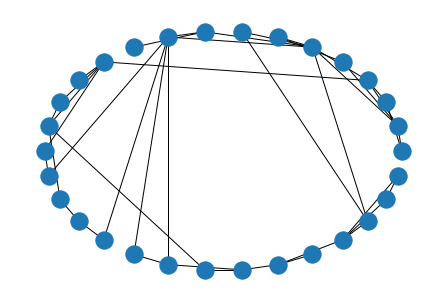

In [267]:
nx.draw(sparsity_graph, nx.circular_layout(sparsity_graph))

In [268]:
treewidth_algorithm_idx = 1
treewidth_algorithms_list = [nx.algorithms.approximation.treewidth_min_degree, nx.algorithms.approximation.treewidth_min_fill_in] # nx.junction_tree
treewidth, tree_decomp = treewidth_algorithms_list[treewidth_algorithm_idx](sparsity_graph)

### Construct enriched supergraph

In [269]:
# tree_decomp = nx.relabel_nodes(tree_decomp, lambda bag : bag.union(frozenset(range(tree_decomp.number_of_nodes(), tree_decomp.number_of_nodes() + treewidth + 1 - len(bag)))) if len(bag) < treewidth + 1 else bag)

In [270]:
G_bar = sparsity_graph.copy()

In [271]:
next_idx = G_bar.number_of_nodes()
T_bar = tree_decomp.copy()

for bag in tree_decomp.nodes:
    if len(bag) < treewidth + 1:
        new_bag = bag.union(frozenset(range(next_idx, next_idx + treewidth + 1 - len(bag))))
        T_bar = nx.relabel_nodes(T_bar, {bag : new_bag})
        next_idx += treewidth + 1 - len(bag)

G_bar.add_nodes_from(range(G_bar.number_of_nodes(), next_idx))

In [272]:
T_tilde = T_bar.copy()

In [273]:
while T_tilde.number_of_nodes() > 1:
    for bag in T_tilde.nodes:
        if T_tilde.degree(bag) == 1:
            parent = list(T_tilde.neighbors(bag))[0]
            Os = sorted(list(bag.difference(parent)))
            Ws = sorted(list(parent.difference(bag)))
            G_bar.add_edges_from([(Os[i], Ws[i]) for i in range(len(Os))])
            T_tilde.remove_node(bag)
            break

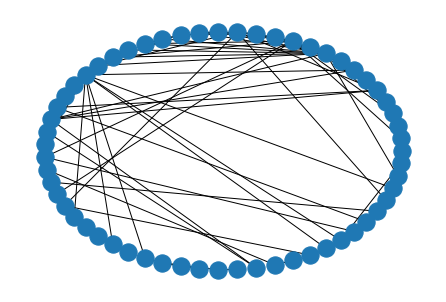

In [274]:
nx.draw(G_bar, nx.circular_layout(G_bar))

### SDP (QCQP)

In [275]:
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y
    Phi_i = 1 / 2 * (Y_i.H + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.H - Y_i)
    Psis.append(Psi_i)

In [276]:
constraints = [X >> 0]

for i in range(n):
    # TODO: multiple generators at one bus
    if i in gens:
        i_gen_idx = list(gens).index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [277]:
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

In [278]:
loss_cost = cp.sum([ cp.sum([ G[i][j] * cp.real(X[i][i] + X[j][j] - X[i][j] - X[j][i]) for j in range(i)]) for i in range(n)])

In [279]:
# original cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# line loss
# prob = cp.Problem(cp.Minimize(loss_cost), constraints)

In [280]:
# prob.solve(solver=cp.SCS, verbose=True)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=False)

/home/ivanightingale/miniconda3/envs/convex/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


574.5167504598561

In [281]:
n_bar = G_bar.number_of_nodes()
X_bar = cp.Variable((n_bar, n_bar), hermitian=True)
X_ref = cp.Parameter((n, n), hermitian=True, value=X.value)
Z = cp.Parameter((n_bar, n_bar), symmetric=True, value=nx.to_numpy_array(G_bar))

low_rank_constraints = [ X_bar >> 0 ]
low_rank_constraints += [ X_bar[k][k] == X_ref[k][k] for k in sparsity_graph.nodes ]
low_rank_constraints += [ X_bar[k][k] == 1 for k in set(G_bar.nodes).difference(set(sparsity_graph.nodes)) ]
low_rank_constraints += [ X_bar[i][j] == X_ref[i][j] for (i,j) in sparsity_graph.edges ]

low_rank_prob = cp.Problem(cp.Minimize(cp.real(cp.trace(Z @ X_bar))), low_rank_constraints)

In [295]:
low_rank_prob.solve()

80.81848915461268

In [296]:
np.linalg.eigvalsh(X_bar.value)

array([-4.72415720e-09, -4.24793091e-09, -3.56268146e-09, -3.22218972e-09,
       -3.03804190e-09, -2.78365694e-09, -2.25634821e-09, -2.14661349e-09,
       -1.87000108e-09, -1.52576459e-09, -6.95705698e-10, -5.33070445e-10,
       -4.93089022e-10, -7.35325208e-11,  1.27964402e-10,  3.60103597e-10,
        1.19792692e-09,  2.15763738e-09,  3.72380868e-09,  8.07224019e-09,
        8.85822900e-09,  1.20252345e-08,  1.64703793e-08,  1.87153761e-08,
        2.51396801e-08,  7.68338694e-08,  1.62208018e-07,  3.19197706e-07,
        3.40643695e-07,  4.35884913e-07,  4.60307245e-07,  4.80637490e-07,
        5.44557729e-07,  5.45036309e-07,  5.52288635e-07,  5.54979533e-07,
        5.66428463e-07,  6.33179658e-07,  6.79714873e-07,  9.07906247e-07,
        9.44428348e-07,  1.19265894e-06,  1.26677489e-06,  1.33527978e-06,
        1.33775949e-06,  1.34533410e-06,  1.35248287e-06,  1.41788609e-06,
        2.54843598e-06,  3.25871858e-06,  3.58074714e-06,  3.58848530e-06,
        3.76478999e-06,  

In [297]:
X.value = X_bar.value[0:n, 0:n]
print(prob.objective.value)

574.5167607626804


In [298]:
# for c in prob.constraints:
#     print(c.violation())

4.535604508087967e-09
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[4.32489964e-09]
[1.56670432e-08]
[1.31572899e-08]
[5.19714973e-08]
[2.49758858e-09]
[6.33472208e-09]
[2.52216967e-08]
[9.25249068e-08]
[5.90179353e-09]
[1.11921477e-08]
[6.04864042e-09]
[1.6629037e-08]
[2.49651192e-10]
[2.88828517e-09]
[2.97793493e-08]
[8.84066731e-08]
[2.56634989e-10]
[5.56691138e-10]
[1.41883574e-08]
[4.25372091e-08]
[0.]
[0.]
[0.]
[0.]
[2.62990268e-09]
[2.72963961e-09]
[1.26511758e-08]
[2.02288893e-08]
[1.23041256e-08]
[2.7200955e-08]
[2.07929024e-08]
[5.15098503e-08]
[4.70694325e-09]
[8.9549369e-09]
[8.71880504e-09]
[1.7950853e-08]
[6.66759746e-09]
[1.46829596e-08]
[1.56037824e-08]
[2.98303443e-08]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[5.81326257e-09]
[8.97724367e-09]
[3.30311711e-09]
[5.33918687e-09]
[1.02732586e-09]
[9.69429627e-10]
[0.]
[0.]
[0.]
[0.]
[3.60045815e-09]
[1.11176917e-08]
[1.22416597e-09]
[1.5907019e-09]
[1.61015358e-09]
[1.33196463e-09]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

### Fixed point iterations

In [299]:
X_ac = cp.Variable((n,n), hermitian=True)

In [300]:
prob_ac = cp.Problem(cp.Maximize(cp.log_det(X_ac) \
                              + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[i] @ X_ac)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[i] @ X_ac)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(q_max[i] - cp.real(cp.trace(Psis[i] @ X_ac)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[i] @ X_ac)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(V_max_sq[i] - cp.real(X_ac[i][i])) + cp.log(cp.real(X_ac[i][i]) - V_min_sq[i]) for i in range(n) ]) ), constraints)

prob_ac.solve(solver=cp.SCS)

-192.63402081501656

In [301]:
# fixed_point_iteration(prob, X, np.zeros((n,n)), True)
fixed_point_iteration(prob, X, -X_ac.value, True)

Initial objective:  891.6963770562318
Initial rank:  25
Current objective:  902.8100401938697
Current rank:  2
Current objective:  902.7934355367432
Current rank:  3
Current objective:  902.7918715336339
Current rank:  3
Current objective:  902.7917019193534
Current rank:  3
Current objective:  902.7916783704982
Current rank:  3
Current objective:  902.791674755081
Current rank:  3
Fixed point objective:  902.7916741829739
Fixed point rank:  3
Fixed point eigenvalues:
[-4.80714352e-12 -4.51945405e-12 -4.44577952e-12 -4.42390813e-12
 -4.23900241e-12 -3.72577481e-12 -3.53017055e-12 -3.47308331e-12
 -3.05309615e-12 -2.43664310e-12 -1.67172855e-12 -1.04972696e-12
 -5.97980866e-13 -2.91674997e-13  2.09686475e-12  3.10073041e-12
  3.60900598e-12  4.03578309e-12  5.31503916e-12  7.88885729e-12
  9.02418223e-12  1.34106231e-11  1.65084891e-11  2.74603966e-11
  8.06747500e-11  1.72471999e-10  4.20436814e-10  1.49228562e-09
  6.86872664e-02  3.29424423e+01]


### Hyperplane rounding

In [304]:
def cost_from_exact_solution(v):
    X_exact = np.outer(v, v.conj())
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [305]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

-25.227532536427802


/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  p_g[i] = p_d[i][0] + G[i][i] * X[i][i] + np.sum(
/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  q_g[i] = q_d[i][0] - B[i][i] * X[i][i] + np.sum(


In [306]:
check_power_feasibility(hyperplane_v, p_min.value, p_max.value, q_min.value, q_max.value, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

active power generation 0 is too low: p_g = -0.037530 < 0.000000
active power generation 3 is too low: p_g = -0.589783 < 0.000000
active power generation 4 is too low: p_g = -0.016970 < 0.000000


In [307]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)